# Ravar, Kerman Province, Iran
https://www.google.com/maps/place/31°11'22.0%22N+57°01'00.0%22E/@31.5704132,56.0492237,797406m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d31.1894444!4d57.0166667?hl=en-AU

In [1]:
import xarray as xr
import numpy as np
import glob
import ee

In [2]:
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Define helper functions

In [3]:
from geomed3dv4 import *

In [4]:
def plot_fractality(ax, data):
    from scipy.stats import linregress
    import numpy as np
    import matplotlib.ticker as ticker

    ax.loglog(data.r, data, base=2, label='Calculated')
    ax.set_xlabel('Wavelength, m', fontsize=18)

    ax.axes.get_yaxis().set_visible(False)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    res = linregress(np.log2(data.r), np.log2(data))
    ax.plot(data.r, 2**(res.intercept + res.slope*np.log2(data.r)), 'r', label=f'Fitted R²={res.rvalue**2:.2f}', ls='--')

    ax.legend(fontsize=18)

    fractality = 1000*np.round((3 - (res.slope/2)),1)
    return fractality

#def plot_preview(ax, GEEimage, filename):
#    image = plt.imread(filename)
#    ax.imshow(image, interpolation='bilinear', extent=gee_image2rect(GEEimage, True))
def plot_preview(ax, GEEimage, filename):
    import matplotlib.ticker as ticker

    image = plt.imread(filename)
    ax.imshow(image, interpolation='bilinear', extent=gee_image2rect(GEEimage, True))
    #ax.ticklabel_format(useOffset=False, style='plain')
    ax1.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: int(x/1000)))
    ax1.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: int(x/1000)))
    ax1.set_ylabel('Y, km', fontsize=18)
    ax1.set_xlabel('X, km', fontsize=18)

## Connect to GEE

In [5]:
service_account = 'console@gee-export-308512.iam.gserviceaccount.com'
service_key = '/Users/mbg/gee-export.json'

In [6]:
credentials = ee.ServiceAccountCredentials(service_account, service_key)
ee.Initialize(credentials)

## Define work area and scale

In [7]:
# define center of work area, decimal degrees
#point = [57.016667, 31.189444]
#point = [57, 31.2]
#import shapely
#gpd.GeoDataFrame(geometry=[shapely.ops.Point(point)], crs=4326).to_crs(32640)
point = [500000, 3450000]

# radius, [m]
radius = 40*1000
# scale, [m]
scale = 100

epsg = 32640

# redefine library function for projected coordinates
def gee_image2rect(GEEimage, reorder=False):
    if not reorder:
        return [point[0]-radius, point[1]-radius, point[0]+radius, point[1]+radius]
    else:
        return [point[0]-radius, point[0]+radius, point[1]-radius, point[1]+radius]

# define spatial components 1*scale .. N*scale [m]
gammas = np.arange(1,101)

#GEEpoint = ee.Geometry.Point(point)
#GEEpoint.getInfo()

#GEEarea = GEEpoint.buffer(radius).bounds()
#GEEarea.getInfo()

#(minx, miny, maxx, maxy)
GEEarea_proj = ee.Geometry.Rectangle(
        coords=gee_image2rect(None),
        proj=f'EPSG:{epsg}',
        geodesic=False
    )
GEEarea_proj.getInfo()

{'geodesic': False,
 'crs': {'type': 'name', 'properties': {'name': 'EPSG:32640'}},
 'type': 'Polygon',
 'coordinates': [[[460000, 3410000],
   [540000, 3410000],
   [540000, 3490000],
   [460000, 3490000],
   [460000, 3410000]]]}

## Prepare image bands

In [8]:
# https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V3_2
GEEdsm = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2").mosaic().select('DSM')

### Sentinel-2 composite image

In [9]:
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
GEEs2srcol = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
    .map(GEEmaskS2clouds)\
    .filterBounds(GEEarea_proj)
GEEs2sr = GEEs2srcol\
    .median()\
    .rename(GEEs2srcol.first().bandNames().map(lambda name: ee.String('S2SR').cat(name)))\
    .select(['S2SRB2','S2SRB3','S2SRB4'])
print ('Collected Sentinel-2 SR images', GEEs2srcol.size().getInfo())
print ('Collected Sentinel-2 SR bands', GEEs2sr.bandNames().getInfo())

Collected Sentinel-2 SR images 405
Collected Sentinel-2 SR bands ['S2SRB2', 'S2SRB3', 'S2SRB4']


## Build image mosaic

In [10]:
GEEimage = \
    GEEs2sr\
    .addBands(GEEdsm)\
    .reproject(crs=f'epsg:{epsg}',scale=scale)
print ('collected bands', GEEimage.bandNames().getInfo())

collected bands ['S2SRB2', 'S2SRB3', 'S2SRB4', 'DSM']


### Make image preview and save on local filesystem
Note: we need to check the image preview quality before the image usage

In [11]:
# define visualization parameters
DEMvis = {'bands':['DSM'], 'min':400, 'max':3100,
          'palette': ['00A600','63C600','E6E600','E9BD3A','ECB176','EFC2B3','F2F2F2']}

In [12]:
print (gee_preview_tofile(GEEimage.clip(GEEarea_proj), DEMvis, (320, 320), 'dempreview.320x320.jpg')['url'])

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6561b8d6244ffae747f1e5c7c3e96082-a144602f8004ce2fa28aed9238ce560d:getPixels


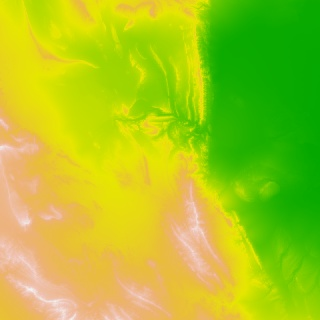

In [13]:
Image('dempreview.320x320.jpg')

In [14]:
# define visualization parameters
S2vis = {'bands':['S2SRB4', 'S2SRB3', 'S2SRB2'], 'min':0, 'max':0.3, 'gamma':1.4}

In [15]:
print (gee_preview_tofile(GEEimage.clip(GEEarea_proj), S2vis, (320, 320), 's2preview.320x320.jpg')['url'])

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/04c8051b488cbd9a62e6dc28c0cbaa4e-7fc023c1176e48f6caf54b89bfb685e4:getPixels


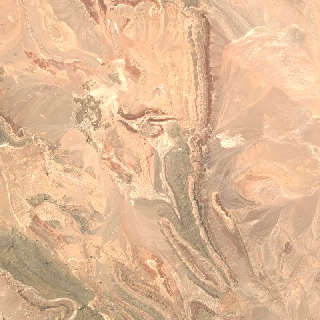

In [16]:
Image('s2preview.320x320.jpg')

### Extract raw image bands and save on local filesystem

In [17]:
GEEurl = GEEimage.getDownloadURL({'filePerBand':True, 'scale': scale, 'region': GEEarea_proj})
print (f'downloading', GEEurl)
fname = f'image.{scale}m.zip'
geeurl_tofile(GEEurl, fname)

downloading https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d495b7777bde58ec91e16d452a4eef89-d7d5c58bf2f519577d85f6df63f79387:getPixels


### Convert downloaded zipped images chunks to compressed NetCDF file

In [18]:
%%time
ds = zipsbands2image(glob.glob(f'image.{scale}m.zip'))

CPU times: user 87.9 ms, sys: 24.2 ms, total: 112 ms
Wall time: 131 ms


In [19]:
# check data variables
for varname in ds.data_vars:
    print (varname, float(ds[varname].min()), float(ds[varname].max()))

S2SRB2 0.040049999952316284 0.3558500111103058
S2SRB3 0.0643249973654747 0.4740000069141388
S2SRB4 0.06527499854564667 0.6201500296592712
DSM 400.0 3157.0


In [20]:
encoding = {var: dict(zlib=True, complevel=6) for var in ds.data_vars}
ds.to_netcdf(f'image.{scale}m.nc', encoding=encoding)
print (ds.dims)

Frozen(SortedKeysDict({'y': 800, 'x': 800}))


## DEM Fractality

In [21]:
dem_power = xr.DataArray([raster_gamma_range(ds.DSM, g-1, g+1, backward=True).std() for g in gammas],
                          coords=[scale*gammas],
                          dims=['r'])

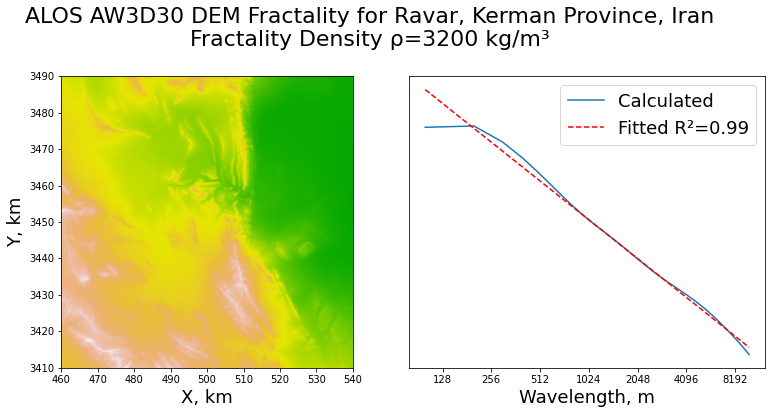

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_preview(ax1, GEEimage, 'dempreview.320x320.jpg')
dem_fractality = plot_fractality(ax2, dem_power)

plt.suptitle(f"ALOS AW3D30 DEM Fractality for Ravar, Kerman Province, Iran\nFractality Density ρ={dem_fractality:.0f} kg/m³", fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.savefig('ALOS AW3D30 DEM Fractality for Ravar, Kerman Province, Iran.jpg', dpi=150)
plt.show()

## Satellite Image Fractality

In [23]:
img_power = xr.DataArray([raster_gamma_range(ds.S2SRB4, g-1, g+1, backward=True).std() for g in gammas],
                          coords=[scale*gammas],
                          dims=['r'])

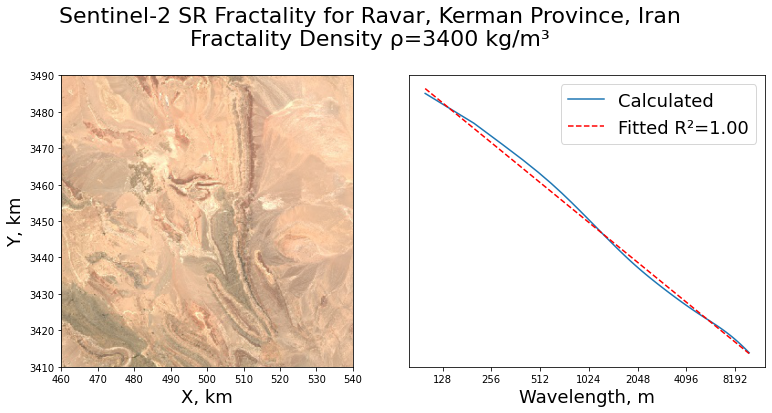

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_preview(ax1, GEEimage, 's2preview.320x320.jpg')
img_fractality = plot_fractality(ax2, img_power)

plt.suptitle(f"Sentinel-2 SR Fractality for Ravar, Kerman Province, Iran\nFractality Density ρ={img_fractality:.0f} kg/m³", fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.savefig('Sentinel-2 SR Fractality for Ravar, Kerman Province, Iran.jpg', dpi=150)
plt.show()

## Pictures Postprocessing

In [25]:
!convert -append \
    'ALOS AW3D30 DEM Fractality for Ravar, Kerman Province, Iran.jpg' \
    'Sentinel-2 SR Fractality for Ravar, Kerman Province, Iran.jpg' \
    'Fractality for Ravar, Kerman Province, Iran.jpg'